In [11]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import matplotlib.pyplot as plt
import seaborn as sns

'''
import tokenization
from wordcloud import STOPWORDS
'''

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

'''
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback


SEED = 1337
'''

'\nimport tensorflow as tf\nimport tensorflow_hub as hub\nfrom tensorflow import keras\nfrom tensorflow.keras.optimizers import SGD, Adam\nfrom tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D\nfrom tensorflow.keras.models import Model, Sequential\nfrom tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback\n\n\nSEED = 1337\n'

In [12]:
df_train = pd.read_csv('train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('test.csv', dtype={'id': np.int16})

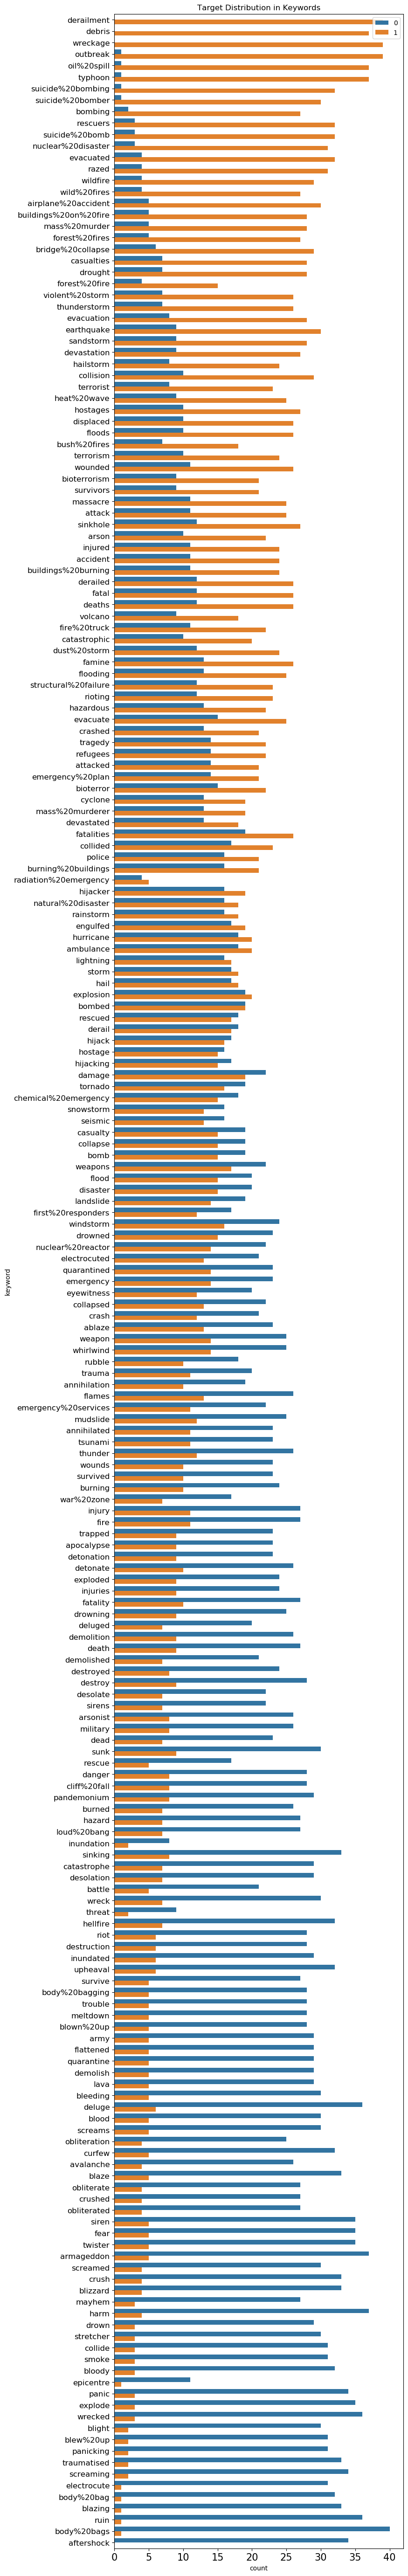

In [9]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

In [13]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in sw]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in sw]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [15]:
glove_embeddings = np.load('glove.840B.300d.pkl', allow_pickle=True)
'''
fasttext_embeddings = np.load('crawl-300d-2M.pkl', allow_pickle=True)
'''

"\nfasttext_embeddings = np.load('crawl-300d-2M.pkl', allow_pickle=True)\n"

In [26]:
def build_vocab(X):
    
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    
    print(vocab)
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

{'Our': 25, 'Deeds': 1, 'are': 345, 'the': 2575, 'Reason': 5, 'of': 1722, 'this': 335, '#earthquake': 8, 'May': 16, 'ALLAH': 1, 'Forgive': 1, 'us': 53, 'all': 178, 'Forest': 29, 'fire': 148, 'near': 50, 'La': 11, 'Ronge': 1, 'Sask.': 1, 'Canada': 4, 'All': 52, 'residents': 4, 'asked': 9, 'to': 1805, "'shelter": 1, 'in': 1757, "place'": 1, 'being': 67, 'notified': 1, 'by': 469, 'officers.': 1, 'No': 53, 'other': 31, 'evacuation': 32, 'or': 181, 'shelter': 4, 'place': 22, 'orders': 11, 'expected': 11, '13,000': 1, 'people': 146, 'receive': 2, '#wildfires': 5, 'California': 89, 'Just': 48, 'got': 103, 'sent': 12, 'photo': 8, 'from': 372, 'Ruby': 1, '#Alaska': 2, 'as': 282, 'smoke': 33, 'pours': 1, 'into': 162, 'a': 1845, 'school': 47, '#RockyFire': 4, 'Update': 6, '=>': 1, 'Hwy.': 4, '20': 13, 'closed': 15, 'both': 20, 'directions': 1, 'due': 27, 'Lake': 8, 'County': 30, '-': 763, '#CAfire': 1, '#flood': 3, '#disaster': 5, 'Heavy': 7, 'rain': 27, 'causes': 10, 'flash': 14, 'flooding': 26,

GloVe Embeddings cover 52.06% of vocabulary and 82.68% of text in Training Set
GloVe Embeddings cover 57.21% of vocabulary and 81.85% of text in Test Set


In [28]:
print(train_glove_oov)

[('\x89Û_', 50), ('MH370:', 39), ('\x89ÛÒ', 38), ('Latest:', 31), ("Legionnaires'", 31), ('#prebreak', 30), ("he's", 28), ('re\x89Û_', 27), ('w/', 26), ("there's", 26), ("'The", 26), ('\x89ÛÓ', 26), ('Legionnaires:', 25), ('a...', 24), ('PM:', 24), ("Confirmed'", 23), ("'Conclusively", 23), ('Typhoon-Devastated', 23), ('#???', 23), ('Saipan:', 22), ('.:', 21), ('were...', 20), ('(Detonation)', 20), ('MH370', 20), ('VIDEO:', 20), ('#Hiroshima', 20), ('#??', 20), ('disea...', 19), ('Photo:', 19), ('bestnaijamade', 18), ("'We're", 18), ("Reddit's", 18), ('Soudelor', 18), ('news!', 17), ('2015]', 17), ('[Black', 17), ('Funtenna:', 17), ("That's", 17), ("won't", 17), ("they're", 17), ("'I", 17), ("What's", 17), ('Crash:', 16), ("water':", 16), ("neighbour's", 16), ('Unconfirmed!', 16), ('#GBBO', 16), ('fires.', 16), ("she's", 16), ("China's", 15), ('quiz:', 15), ("ain't", 15), ("Can't", 15), ('MP:', 14), ("wasn't", 14), ("crematoria'", 13), ('UTC2015-08-05', 13), ('don\x89Ûªt', 13), ("aren'

In [37]:
df_mislabeled = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

In [38]:
df_train['target_relabeled'] = df_train['target'].copy() 

df_train.loc[df_train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0